In [1]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD, RMSprop, Adam, Adagrad, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import random
# import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import scipy
import skimage
from skimage.transform import resize
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

2023-09-10 20:51:38.686126: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 20:51:38.873501: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-10 20:51:42.000578: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-10 20:51:42.000735: W tensorflow/strea

2.10.1


In [2]:
# !git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset.git

In [3]:
# !pip install split-folders 

In [4]:
# import splitfolders
# import os

In [5]:
# path = "Sign-Language-Digits-Dataset/Dataset"

# splitfolders.ratio(path, seed=777, output="Train-Validation-Test-Dataset", ratio=(0.7, 0.15, 0.15))

In [6]:
train_path = "Train-Validation-Test-Dataset/train"
val_path = "Train-Validation-Test-Dataset/val"
test_path = "Train-Validation-Test-Dataset/test"

In [7]:
from tensorflow.keras.preprocessing.image   import ImageDataGenerator

##Clasificamos las imagenes
bs = 32 #bach size
k = 2
# Generador de imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=(0.3),
        zoom_range=(0.3),
        width_shift_range=(0.2),
        height_shift_range=(0.2),
        # validation_split = 0.2,
        brightness_range=(0.05,0.85),
        horizontal_flip=False)

# Carga de imágenes al generador de entrenamiento desde directorio.
train_generator = train_datagen.flow_from_directory(
        train_path,
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'training',
        batch_size=bs)

valid_generator = train_datagen.flow_from_directory(
        val_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

test_generator = train_datagen.flow_from_directory(
        test_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

Found 1438 images belonging to 10 classes.
Found 304 images belonging to 10 classes.
Found 320 images belonging to 10 classes.


In [8]:
from numpy.random import seed
tf.keras.utils.set_random_seed(42)# keras seed fixing
tf.random.set_seed(42)# tensorflow seed fixing

#Visualizamos la estructura del modelo que vamos a utilizar
model = tf.keras.applications.VGG19()
model.summary()
print(len(model.layers))

2023-09-10 20:51:46.726502: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-10 20:51:46.726550: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-10 20:51:46.726594: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (21a56a7ceb29): /proc/driver/nvidia/version does not exist
2023-09-10 20:51:46.726830: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
##DEFINIMOS EL MODELO
num_classes = 10
epochs = 100

# VGG19
# Importamos el modelo que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

print(len(VGG19_model.layers))
#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
from tensorflow.keras import regularizers
model.add(Flatten())
model.add(Dense(512, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))

22


In [10]:
from numpy.random import seed
tf.keras.utils.set_random_seed(42)# keras seed fixing
tf.random.set_seed(42)# tensorflow seed fixing

## EJECUCION DEL MODELO
model.compile(loss="categorical_crossentropy", 
              optimizer= SGD(learning_rate=0.001),
              metrics=['accuracy'])

#Agregamos un callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='model-04', verbose=1, save_best_only=True,
                               monitor = 'accuracy', mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.000001)

history= model.fit(train_generator, callbacks = [reduce_lr, checkpointer], epochs=epochs)

Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 7.4814 - accuracy: 0.1113
Epoch 1: accuracy improved from -inf to 0.11127, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 105s 2s/step - loss: 7.4814 - accuracy: 0.1113 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 7.3739 - accuracy: 0.1766
Epoch 2: accuracy improved from 0.11127 to 0.17663, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 101s 2s/step - loss: 7.3739 - accuracy: 0.1766 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 7.2138 - accuracy: 0.2538
Epoch 3: accuracy improved from 0.17663 to 0.25382, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 101s 2s/step - loss: 7.2138 - accuracy: 0.2538 - lr: 0.0010
Epoch 4/100
45/45 [==============================] - ETA: 0s - loss: 6.9706 - accuracy: 0.3387
Epoch 4: accuracy improved from 0.25382 to 0.33866, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 101s 2s/step - loss: 6.9706 - accuracy: 0.3387 - lr: 0.0010
Epoch 5/100
45/45 [==============================] - ETA: 0s - loss: 6.7599 - accuracy: 0.3901
Epoch 5: accuracy improved from 0.33866 to 0.39013, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 102s 2s/step - loss: 6.7599 - accuracy: 0.3901 - lr: 0.0010
Epoch 6/100
45/45 [==============================] - ETA: 0s - loss: 6.5756 - accuracy: 0.4652
Epoch 6: accuracy improved from 0.39013 to 0.46523, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 103s 2s/step - loss: 6.5756 - accuracy: 0.4652 - lr: 0.0010
Epoch 7/100
45/45 [==============================] - ETA: 0s - loss: 6.3433 - accuracy: 0.5341
Epoch 7: accuracy improved from 0.46523 to 0.53408, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 103s 2s/step - loss: 6.3433 - accuracy: 0.5341 - lr: 0.0010
Epoch 8/100
45/45 [==============================] - ETA: 0s - loss: 6.1852 - accuracy: 0.5925
Epoch 8: accuracy improved from 0.53408 to 0.59249, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 103s 2s/step - loss: 6.1852 - accuracy: 0.5925 - lr: 0.0010
Epoch 9/100
45/45 [==============================] - ETA: 0s - loss: 6.0176 - accuracy: 0.6572
Epoch 9: accuracy improved from 0.59249 to 0.65716, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 103s 2s/step - loss: 6.0176 - accuracy: 0.6572 - lr: 0.0010
Epoch 10/100
45/45 [==============================] - ETA: 0s - loss: 5.8803 - accuracy: 0.7114
Epoch 10: accuracy improved from 0.65716 to 0.71140, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 102s 2s/step - loss: 5.8803 - accuracy: 0.7114 - lr: 0.0010
Epoch 11/100
45/45 [==============================] - ETA: 0s - loss: 5.7500 - accuracy: 0.7448
Epoch 11: accuracy improved from 0.71140 to 0.74478, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 102s 2s/step - loss: 5.7500 - accuracy: 0.7448 - lr: 0.0010
Epoch 12/100
45/45 [==============================] - ETA: 0s - loss: 5.6290 - accuracy: 0.7837
Epoch 12: accuracy improved from 0.74478 to 0.78373, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 103s 2s/step - loss: 5.6290 - accuracy: 0.7837 - lr: 0.0010
Epoch 13/100
45/45 [==============================] - ETA: 0s - loss: 5.6041 - accuracy: 0.7962
Epoch 13: accuracy improved from 0.78373 to 0.79624, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 103s 2s/step - loss: 5.6041 - accuracy: 0.7962 - lr: 0.0010
Epoch 14/100
45/45 [==============================] - ETA: 0s - loss: 5.4692 - accuracy: 0.8394
Epoch 14: accuracy improved from 0.79624 to 0.83936, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 103s 2s/step - loss: 5.4692 - accuracy: 0.8394 - lr: 0.0010
Epoch 15/100
45/45 [==============================] - ETA: 0s - loss: 5.4186 - accuracy: 0.8519
Epoch 15: accuracy improved from 0.83936 to 0.85188, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 104s 2s/step - loss: 5.4186 - accuracy: 0.8519 - lr: 0.0010
Epoch 16/100
45/45 [==============================] - ETA: 0s - loss: 5.4045 - accuracy: 0.8512
Epoch 16: accuracy did not improve from 0.85188
45/45 [==============================] - 100s 2s/step - loss: 5.4045 - accuracy: 0.8512 - lr: 0.0010
Epoch 17/100
45/45 [==============================] - ETA: 0s - loss: 5.3666 - accuracy: 0.8734
Epoch 17: accuracy improved from 0.85188 to 0.87344, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 103s 2s/step - loss: 5.3666 - accuracy: 0.8734 - lr: 0.0010
Epoch 18/100
45/45 [==============================] - ETA: 0s - loss: 5.2929 - accuracy: 0.8964
Epoch 18: accuracy improved from 0.87344 to 0.89638, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 100s 2s/step - loss: 5.2929 - accuracy: 0.8964 - lr: 0.0010
Epoch 19/100
45/45 [==============================] - ETA: 0s - loss: 5.2811 - accuracy: 0.8922
Epoch 19: accuracy did not improve from 0.89638
45/45 [==============================] - 97s 2s/step - loss: 5.2811 - accuracy: 0.8922 - lr: 0.0010
Epoch 20/100
45/45 [==============================] - ETA: 0s - loss: 5.2534 - accuracy: 0.8971
Epoch 20: accuracy improved from 0.89638 to 0.89708, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 101s 2s/step - loss: 5.2534 - accuracy: 0.8971 - lr: 0.0010
Epoch 21/100
45/45 [==============================] - ETA: 0s - loss: 5.1933 - accuracy: 0.9221
Epoch 21: accuracy improved from 0.89708 to 0.92211, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 102s 2s/step - loss: 5.1933 - accuracy: 0.9221 - lr: 0.0010
Epoch 22/100
45/45 [==============================] - ETA: 0s - loss: 5.2284 - accuracy: 0.8992
Epoch 22: accuracy did not improve from 0.92211
45/45 [==============================] - 97s 2s/step - loss: 5.2284 - accuracy: 0.8992 - lr: 0.0010
Epoch 23/100
45/45 [==============================] - ETA: 0s - loss: 5.2037 - accuracy: 0.9082
Epoch 23: accuracy did not improve from 0.92211
45/45 [==============================] - 96s 2s/step - loss: 5.2037 - accuracy: 0.9082 - lr: 0.0010
Epoch 24/100
45/45 [==============================] - ETA: 0s - loss: 5.1431 - accuracy: 0.9284
Epoch 24: accuracy improved from 0.92211 to 0.92837, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 102s 2s/step - loss: 5.1431 - accuracy: 0.9284 - lr: 0.0010
Epoch 25/100
45/45 [==============================] - ETA: 0s - loss: 5.1478 - accuracy: 0.9221
Epoch 25: accuracy did not improve from 0.92837
45/45 [==============================] - 97s 2s/step - loss: 5.1478 - accuracy: 0.9221 - lr: 0.0010
Epoch 26/100
45/45 [==============================] - ETA: 0s - loss: 5.1007 - accuracy: 0.9256
Epoch 26: accuracy did not improve from 0.92837
45/45 [==============================] - 97s 2s/step - loss: 5.1007 - accuracy: 0.9256 - lr: 0.0010
Epoch 27/100
45/45 [==============================] - ETA: 0s - loss: 5.0744 - accuracy: 0.9353
Epoch 27: accuracy improved from 0.92837 to 0.93533, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 105s 2s/step - loss: 5.0744 - accuracy: 0.9353 - lr: 0.0010
Epoch 28/100
45/45 [==============================] - ETA: 0s - loss: 5.0907 - accuracy: 0.9270
Epoch 28: accuracy did not improve from 0.93533
45/45 [==============================] - 101s 2s/step - loss: 5.0907 - accuracy: 0.9270 - lr: 0.0010
Epoch 29/100
45/45 [==============================] - ETA: 0s - loss: 5.0519 - accuracy: 0.9374
Epoch 29: accuracy improved from 0.93533 to 0.93741, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 104s 2s/step - loss: 5.0519 - accuracy: 0.9374 - lr: 0.0010
Epoch 30/100
45/45 [==============================] - ETA: 0s - loss: 5.0504 - accuracy: 0.9381
Epoch 30: accuracy improved from 0.93741 to 0.93811, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 100s 2s/step - loss: 5.0504 - accuracy: 0.9381 - lr: 0.0010
Epoch 31/100
45/45 [==============================] - ETA: 0s - loss: 5.0229 - accuracy: 0.9485
Epoch 31: accuracy improved from 0.93811 to 0.94854, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 100s 2s/step - loss: 5.0229 - accuracy: 0.9485 - lr: 0.0010
Epoch 32/100
45/45 [==============================] - ETA: 0s - loss: 5.0380 - accuracy: 0.9360
Epoch 32: accuracy did not improve from 0.94854
45/45 [==============================] - 95s 2s/step - loss: 5.0380 - accuracy: 0.9360 - lr: 0.0010
Epoch 33/100
45/45 [==============================] - ETA: 0s - loss: 4.9806 - accuracy: 0.9534
Epoch 33: accuracy improved from 0.94854 to 0.95341, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 100s 2s/step - loss: 4.9806 - accuracy: 0.9534 - lr: 0.0010
Epoch 34/100
45/45 [==============================] - ETA: 0s - loss: 4.9617 - accuracy: 0.9624
Epoch 34: accuracy improved from 0.95341 to 0.96245, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 100s 2s/step - loss: 4.9617 - accuracy: 0.9624 - lr: 0.0010
Epoch 35/100
45/45 [==============================] - ETA: 0s - loss: 4.9637 - accuracy: 0.9569
Epoch 35: accuracy did not improve from 0.96245
45/45 [==============================] - 98s 2s/step - loss: 4.9637 - accuracy: 0.9569 - lr: 0.0010
Epoch 36/100
45/45 [==============================] - ETA: 0s - loss: 4.9469 - accuracy: 0.9541
Epoch 36: accuracy did not improve from 0.96245
45/45 [==============================] - 96s 2s/step - loss: 4.9469 - accuracy: 0.9541 - lr: 0.0010
Epoch 37/100
45/45 [==============================] - ETA: 0s - loss: 4.9575 - accuracy: 0.9534
Epoch 37: accuracy did not improve from 0.96245
45/45 [==============================] - 96s 2s/step - loss: 4.9575 - accuracy: 0.9534 - lr: 0.0010
Epoch 38/100
45/45 [==============================] - ETA: 0s - loss: 4.9307 - accuracy: 0.9604
Epoch 38: accuracy did not improve from 0.96245
45/45 [================

INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 99s 2s/step - loss: 4.8734 - accuracy: 0.9673 - lr: 0.0010
Epoch 43/100
45/45 [==============================] - ETA: 0s - loss: 4.8631 - accuracy: 0.9631
Epoch 43: accuracy did not improve from 0.96732
45/45 [==============================] - 97s 2s/step - loss: 4.8631 - accuracy: 0.9631 - lr: 0.0010
Epoch 44/100
45/45 [==============================] - ETA: 0s - loss: 4.8371 - accuracy: 0.9673
Epoch 44: accuracy did not improve from 0.96732
45/45 [==============================] - 101s 2s/step - loss: 4.8371 - accuracy: 0.9673 - lr: 0.0010
Epoch 45/100
45/45 [==============================] - ETA: 0s - loss: 4.8681 - accuracy: 0.9562
Epoch 45: accuracy did not improve from 0.96732
45/45 [==============================] - 98s 2s/step - loss: 4.8681 - accuracy: 0.9562 - lr: 0.0010
Epoch 46/100
45/45 [==============================] - ETA: 0s - loss: 4.8316 - accuracy: 0.9659
Epoch 46: accuracy did not improve from 0.96732
45/45 [================

INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 101s 2s/step - loss: 4.7704 - accuracy: 0.9791 - lr: 0.0010
Epoch 52/100
45/45 [==============================] - ETA: 0s - loss: 4.7828 - accuracy: 0.9673
Epoch 52: accuracy did not improve from 0.97914
45/45 [==============================] - 97s 2s/step - loss: 4.7828 - accuracy: 0.9673 - lr: 0.0010
Epoch 53/100
45/45 [==============================] - ETA: 0s - loss: 4.7651 - accuracy: 0.9715
Epoch 53: accuracy did not improve from 0.97914
45/45 [==============================] - 94s 2s/step - loss: 4.7651 - accuracy: 0.9715 - lr: 0.0010
Epoch 54/100
45/45 [==============================] - ETA: 0s - loss: 4.7577 - accuracy: 0.9687
Epoch 54: accuracy did not improve from 0.97914
45/45 [==============================] - 95s 2s/step - loss: 4.7577 - accuracy: 0.9687 - lr: 0.0010
Epoch 55/100
45/45 [==============================] - ETA: 0s - loss: 4.7535 - accuracy: 0.9687
Epoch 55: accuracy did not improve from 0.97914
45/45 [================

INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 100s 2s/step - loss: 4.6681 - accuracy: 0.9805 - lr: 0.0010
Epoch 62/100
45/45 [==============================] - ETA: 0s - loss: 4.6712 - accuracy: 0.9750
Epoch 62: accuracy did not improve from 0.98053
45/45 [==============================] - 94s 2s/step - loss: 4.6712 - accuracy: 0.9750 - lr: 0.0010
Epoch 63/100
45/45 [==============================] - ETA: 0s - loss: 4.6624 - accuracy: 0.9764
Epoch 63: accuracy did not improve from 0.98053
45/45 [==============================] - 95s 2s/step - loss: 4.6624 - accuracy: 0.9764 - lr: 0.0010
Epoch 64/100
45/45 [==============================] - ETA: 0s - loss: 4.6481 - accuracy: 0.9743
Epoch 64: accuracy did not improve from 0.98053
45/45 [==============================] - 97s 2s/step - loss: 4.6481 - accuracy: 0.9743 - lr: 0.0010
Epoch 65/100
45/45 [==============================] - ETA: 0s - loss: 4.6418 - accuracy: 0.9771
Epoch 65: accuracy did not improve from 0.98053
45/45 [================

INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 100s 2s/step - loss: 4.6065 - accuracy: 0.9826 - lr: 0.0010
Epoch 69/100
45/45 [==============================] - ETA: 0s - loss: 4.6068 - accuracy: 0.9791
Epoch 69: accuracy did not improve from 0.98261
45/45 [==============================] - 94s 2s/step - loss: 4.6068 - accuracy: 0.9791 - lr: 0.0010
Epoch 70/100
45/45 [==============================] - ETA: 0s - loss: 4.6149 - accuracy: 0.9687
Epoch 70: accuracy did not improve from 0.98261
45/45 [==============================] - 93s 2s/step - loss: 4.6149 - accuracy: 0.9687 - lr: 0.0010
Epoch 71/100
45/45 [==============================] - ETA: 0s - loss: 4.5939 - accuracy: 0.9771
Epoch 71: accuracy did not improve from 0.98261
45/45 [==============================] - 96s 2s/step - loss: 4.5939 - accuracy: 0.9771 - lr: 0.0010
Epoch 72/100
45/45 [==============================] - ETA: 0s - loss: 4.6034 - accuracy: 0.9701
Epoch 72: accuracy did not improve from 0.98261
45/45 [================

INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 100s 2s/step - loss: 4.5068 - accuracy: 0.9833 - lr: 0.0010
Epoch 80/100
45/45 [==============================] - ETA: 0s - loss: 4.5186 - accuracy: 0.9743
Epoch 80: accuracy did not improve from 0.98331
45/45 [==============================] - 98s 2s/step - loss: 4.5186 - accuracy: 0.9743 - lr: 0.0010
Epoch 81/100
45/45 [==============================] - ETA: 0s - loss: 4.4985 - accuracy: 0.9777
Epoch 81: accuracy did not improve from 0.98331
45/45 [==============================] - 99s 2s/step - loss: 4.4985 - accuracy: 0.9777 - lr: 0.0010
Epoch 82/100
45/45 [==============================] - ETA: 0s - loss: 4.4964 - accuracy: 0.9812
Epoch 82: accuracy did not improve from 0.98331
45/45 [==============================] - 98s 2s/step - loss: 4.4964 - accuracy: 0.9812 - lr: 0.0010
Epoch 83/100
45/45 [==============================] - ETA: 0s - loss: 4.4951 - accuracy: 0.9764
Epoch 83: accuracy did not improve from 0.98331
45/45 [================

INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 105s 2s/step - loss: 4.4457 - accuracy: 0.9854 - lr: 0.0010
Epoch 88/100
45/45 [==============================] - ETA: 0s - loss: 4.4444 - accuracy: 0.9812
Epoch 88: accuracy did not improve from 0.98540
45/45 [==============================] - 99s 2s/step - loss: 4.4444 - accuracy: 0.9812 - lr: 0.0010
Epoch 89/100
45/45 [==============================] - ETA: 0s - loss: 4.4288 - accuracy: 0.9868
Epoch 89: accuracy improved from 0.98540 to 0.98679, saving model to model-04


INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 103s 2s/step - loss: 4.4288 - accuracy: 0.9868 - lr: 0.0010
Epoch 90/100
45/45 [==============================] - ETA: 0s - loss: 4.4161 - accuracy: 0.9819
Epoch 90: accuracy did not improve from 0.98679
45/45 [==============================] - 100s 2s/step - loss: 4.4161 - accuracy: 0.9819 - lr: 0.0010
Epoch 91/100
45/45 [==============================] - ETA: 0s - loss: 4.4320 - accuracy: 0.9771
Epoch 91: accuracy did not improve from 0.98679
45/45 [==============================] - 100s 2s/step - loss: 4.4320 - accuracy: 0.9771 - lr: 0.0010
Epoch 92/100
45/45 [==============================] - ETA: 0s - loss: 4.3978 - accuracy: 0.9854
Epoch 92: accuracy did not improve from 0.98679
45/45 [==============================] - 100s 2s/step - loss: 4.3978 - accuracy: 0.9854 - lr: 0.0010
Epoch 93/100
45/45 [==============================] - ETA: 0s - loss: 4.4032 - accuracy: 0.9819
Epoch 93: accuracy did not improve from 0.98679
45/45 [=============

INFO:tensorflow:Assets written to: model-04/assets


INFO:tensorflow:Assets written to: model-04/assets


45/45 [==============================] - 105s 2s/step - loss: 4.3457 - accuracy: 0.9875 - lr: 0.0010
Epoch 99/100
45/45 [==============================] - ETA: 0s - loss: 4.3443 - accuracy: 0.9861
Epoch 99: accuracy did not improve from 0.98748
45/45 [==============================] - 100s 2s/step - loss: 4.3443 - accuracy: 0.9861 - lr: 0.0010
Epoch 100/100
45/45 [==============================] - ETA: 0s - loss: 4.3348 - accuracy: 0.9847
Epoch 100: accuracy did not improve from 0.98748
45/45 [==============================] - 103s 2s/step - loss: 4.3348 - accuracy: 0.9847 - lr: 0.0010


In [11]:
preds_test = model.predict(test_generator)

10/10 [==============================] - 7s 665ms/step


In [12]:
evaluate_test = model.evaluate(test_generator)

10/10 [==============================] - 6s 580ms/step - loss: 4.3687 - accuracy: 0.9750


In [13]:
evaluate_test

[4.36872673034668, 0.9750000238418579]

In [14]:
y_preds_test = np.array([np.argmax(x) for x in preds_test])
y_preds_test

array([6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       6, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 6, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 8, 7, 1, 7, 8, 8, 9, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 7, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [15]:
y_real_test = test_generator.classes
y_real_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [16]:
accuracy_test = accuracy_score(y_real_test, y_preds_test)
accuracy_test

0.95625

In [17]:
cm_test = confusion_matrix(y_real_test, y_preds_test)
cm_test

array([[31,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0, 32,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 31,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 32,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 29,  0,  3,  0,  0,  0],
       [ 0,  0,  0,  0,  2, 30,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 32,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0, 29,  2,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1, 29,  2],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0, 31]])

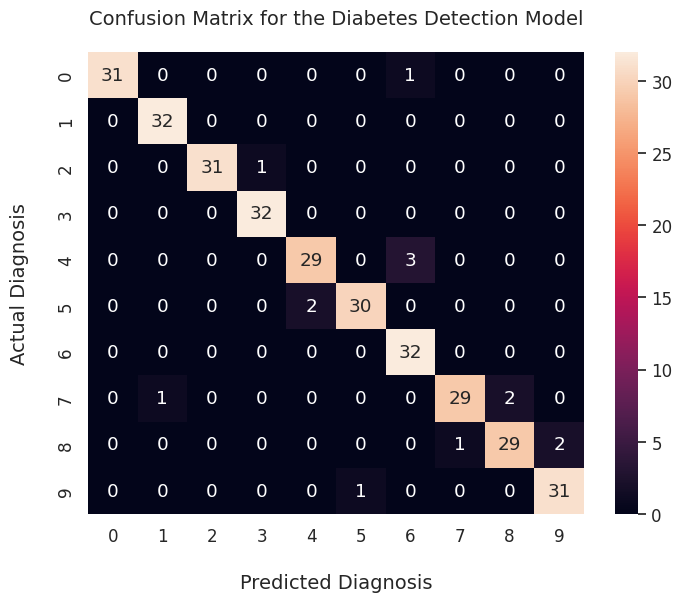

In [18]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_test, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()

In [19]:
preds_val = model.predict(valid_generator)

10/10 [==============================] - 6s 578ms/step


In [20]:
evaluate_val = model.evaluate(valid_generator)

10/10 [==============================] - 6s 636ms/step - loss: 4.3994 - accuracy: 0.9704


In [21]:
evaluate_val

[4.399399757385254, 0.9703947305679321]

In [22]:
y_preds_val = np.array([np.argmax(x) for x in preds_val])
y_preds_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7,
       6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 7, 3,
       7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [23]:
y_real_val = valid_generator.classes
y_real_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [24]:
accuracy_val = accuracy_score(y_real_val, y_preds_val)
accuracy_val

0.9736842105263158

In [25]:
cm_val = confusion_matrix(y_real_val, y_preds_val)
cm_val

array([[30,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 30,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 29,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 29,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 29,  1,  1,  0,  0,  0],
       [ 0,  0,  0,  1,  0, 30,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 31,  0,  0,  0],
       [ 0,  0,  1,  1,  0,  0,  1, 27,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 31,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 30]])

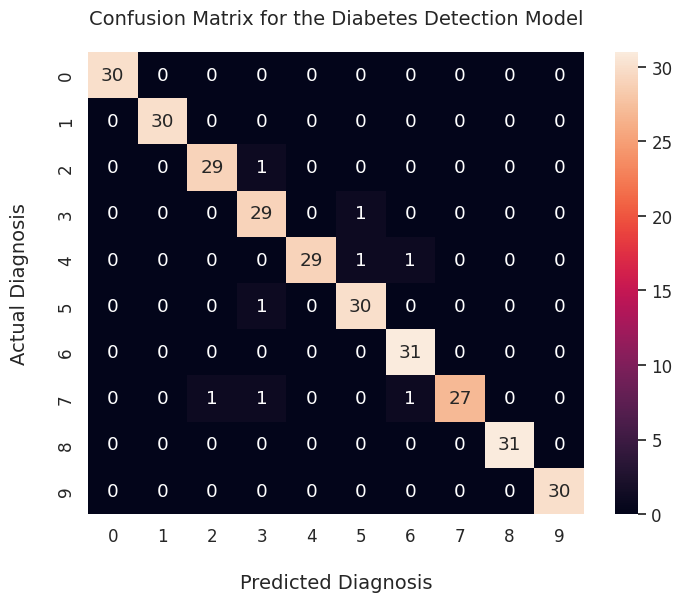

In [26]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_val, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()